# Multilayer Perceptrons

In [1]:
%matplotlib inline

import io
import requests
import logging
import itertools
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (mean_squared_error, r2_score,
                             confusion_matrix, ConfusionMatrixDisplay)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Restrict tensorflow output to errors
logging.getLogger('tensorflow').setLevel(logging.ERROR)

# Make this notebook's output stable across runs
random_state = 100
np.random.seed(random_state)
tf.random.set_seed(random_state)

# Plot formatting
%matplotlib inline
sns.set()
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## Regression: Revenue Forecasting

In [2]:
url = 'https://raw.githubusercontent.com/natecraig/aiml/main/Data/closings.csv'
download = requests.get(url).content
df = pd.read_csv(io.StringIO(download.decode('utf-8')))
df.head()

,StoreType,LiquidationRevenue,InventoryAtTicket,LastYearRevenue,MedianHouseholdIncome,MedianAge
0,Bookstore,1214776.2,2195069.8,465237.3,51290,37.8
1,Bookstore,1811896.9,3152301.9,897704.5,46702,33.4
2,Bookstore,1157614.7,2229837.5,477804.8,86804,41.7
3,Bookstore,2037136.2,3857466.8,1036097.7,83544,40.3
4,Bookstore,1326821.1,2345263.8,612793.5,23508,31.9


In [3]:
# Predict LiquidationRevenue as a function of all available variables
df['Bookstore'] = df['StoreType'].map(lambda x: 1 if x == 'Bookstore' else 0)
feature_vars = ['Bookstore', 'InventoryAtTicket', 'LastYearRevenue',
                'MedianHouseholdIncome', 'MedianAge']
X = df[feature_vars]
y = df['LiquidationRevenue']

# Split data into training and testing sets
(X_train_full, X_test, 
 y_train_full, y_test) = train_test_split(X, y, test_size=0.2,
                                          stratify=df['StoreType'],
                                          random_state=random_state)

# Split training data into training and validation subsets
(X_train, X_valid, 
 y_train, y_valid) = train_test_split(X_train_full, y_train_full,
                                      test_size=0.2,
                                      stratify=X_train_full['Bookstore'],
                                      random_state=random_state)

# Scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [4]:
X_train.shape[1:]

(5,)

In [5]:
# Create model
tf.keras.backend.clear_session()

model = keras.models.Sequential([
    keras.layers.Dense(
        25, activation='relu',
        input_shape=X_train.shape[1:]
    ),
    keras.layers.Dense(1)
])

# Adam is an algorithm based on adaptive moment estimation
# See HOML Chapter 11 for details
opt = keras.optimizers.Adam(learning_rate=0.1)
model.compile(loss='mse', optimizer=opt)

# Saving a model
model.save('mlp_regression_initial.h5')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 25)                150       
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 176
Trainable params: 176
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Note: changing the verbose argument of the model's fit function
# to 1 or 2 will give more information during training
history = model.fit(X_train, y_train, epochs=2500,
                    validation_data=(X_valid, y_valid),
                    batch_size=32, verbose=0)

2023-03-02 11:44:23.805848: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [7]:
# Evaluate on test data
# For reference, XGBoost example performance on test data was
# RMSE: 190806.735
# R2:   0.924
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'RMSE: {np.sqrt(mse):.3f}\n'
      f'R2:   {r2_score(y_test, y_pred):.3f}\n')

4/4 [==============================] - 0s 642us/step
RMSE: 165010.134
R2:   0.942



In [8]:
model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    batch_size=32, verbose=2)

12/12 - 0s - loss: 27074662400.0000 - val_loss: 29493780480.0000 - 29ms/epoch - 2ms/step


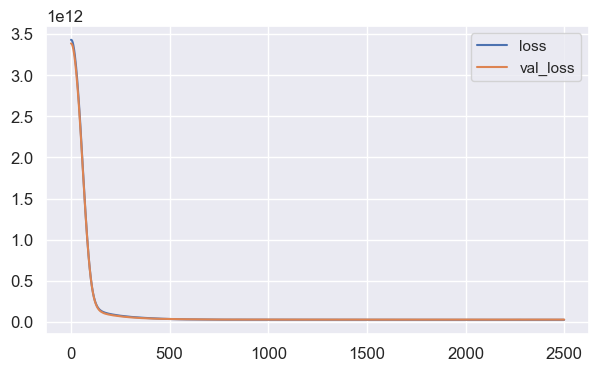

In [9]:
# Chart the learning process
pd.DataFrame(history.history).plot(figsize=(7, 4))
plt.grid(True)
plt.show()

### Exercise

What does the plot of training and validation loss over epochs tell you?

In [10]:
# Loading a model
model = keras.models.load_model('mlp_regression_initial.h5')

# Using callbacks to fit a model while saving the
# best performer on the validation data
checkpoint_cb = keras.callbacks.ModelCheckpoint('mlp_regression_best.h5',
                                                save_best_only=True)

history = model.fit(X_train, y_train, epochs=2000,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb],
                    verbose=0)

model = keras.models.load_model('mlp_regression_best.h5')

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'RMSE: {np.sqrt(mse):.3f}\n'
      f'R2:   {r2_score(y_test, y_pred):.3f}\n')

4/4 [==============================] - 0s 627us/step
RMSE: 166952.703
R2:   0.941



In [11]:
# Using an early-stopping callback to stop after 10 epochs with no improvement
model = keras.models.load_model('mlp_regression_initial.h5')

history = model.fit(X_train, y_train, epochs=2000,
                    validation_data=(X_valid, y_valid),
                    callbacks = [keras.callbacks.EarlyStopping(patience = 10)],
                    verbose=0)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'RMSE: {np.sqrt(mse):.3f}\n'
      f'R2:   {r2_score(y_test, y_pred):.3f}\n')    

4/4 [==============================] - 0s 574us/step
RMSE: 172825.081
R2:   0.936



In [12]:
# Use the KerasRegressor wrapper to allow a sklearn grid search
# for optimizing hyperparameters
def build_model(n_hidden=1, n_neurons=30, learning_rate=0.1,
                input_shape=[5]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation='relu'))
        model.add(keras.layers.Dense(1))

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='mse', optimizer=optimizer)
    
    return model 


parameters = {
    'learning_rate': [0.4, 0.5]
}

# Suppress warning regarding deprecation of KerasRegressor
import warnings
warnings.filterwarnings('ignore')

keras_reg = KerasRegressor(build_model)
grid_cv = GridSearchCV(keras_reg, parameters)
grid_cv.fit(X_train, y_train, epochs=3000, 
            validation_data=(X_valid, y_valid),
            callbacks = [keras.callbacks.EarlyStopping(patience=100)],
            verbose=0)

3/3 [==============================] - 0s 735us/step - loss: 24214528000.0000


GridSearchCV(estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x295b946a0>,
             param_grid={'learning_rate': [0.4, 0.5]})

In [13]:
# Get best parameters and score
print(grid_cv.best_params_)
print(grid_cv.best_score_)

{'learning_rate': 0.5}
-30701040844.8


In [14]:
# Get the best performing model
model = grid_cv.best_estimator_.model
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 30)                180       
                                                                 
 dense_23 (Dense)            (None, 1)                 31        
                                                                 
Total params: 211
Trainable params: 211
Non-trainable params: 0
_________________________________________________________________


In [15]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'RMSE: {np.sqrt(mse):.3f}\n'
      f'R2:   {r2_score(y_test, y_pred):.3f}\n')   

4/4 [==============================] - 0s 594us/step
RMSE: 167579.614
R2:   0.940



### Exercise

Does adding another layer improve the model?

## Classification: Image Processing

In [16]:
# Load fashion MNIST data
fashion_mnist = keras.datasets.fashion_mnist

((X_train_full, y_train_full),
    (X_test, y_test)) = fashion_mnist.load_data() 

X_valid = X_train_full[:5000] / 255.0
X_train = X_train_full[5000:] / 255.0
y_valid = y_train_full[:5000]
y_train = y_train_full[5000:]
X_test = X_test / 255.0 

class_names = [
    'T-Shirt or Top', 'Trouser', 'Pullover', 
    'Dress', 'Coat', 'Sandal', 'Shirt', 
    'Sneaker', 'Bag', 'Ankle Boot'
]

In [17]:
# Show raw data
X_train[0][0,:]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00392157,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ])

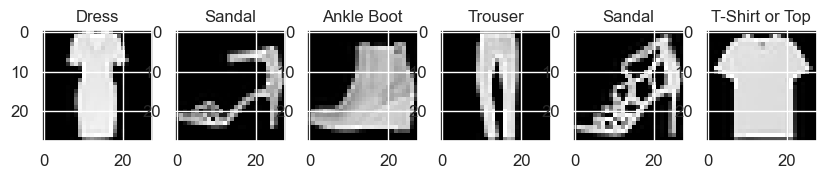

In [18]:
# Output random training instances as images
fig, ax = plt.subplots(1, 6, figsize=(10, 4))
locs = np.random.randint(0, 5000, 6)
for i, a in enumerate(ax):
    a.imshow(X_train[locs[i]], cmap='gray')
    a.set_title(class_names[y_train[locs[i]]])

plt.show()

In [19]:
X_train[0].shape

(28, 28)

In [20]:
28*28

784

In [21]:
len(class_names)

10

In [22]:
# Create a model with two hidden layers
tf.keras.backend.clear_session()

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape = X_train[0].shape))
model.add(keras.layers.Dense(300, activation='relu'))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(len(class_names), activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [23]:
# Fit the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=30, batch_size=32,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.7126 - accuracy: 0.7667 - val_loss: 0.5769 - val_accuracy: 0.8026
Epoch 2/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4835 - accuracy: 0.8331 - val_loss: 0.4334 - val_accuracy: 0.8508
Epoch 3/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4385 - accuracy: 0.8465 - val_loss: 0.3997 - val_accuracy: 0.8612
Epoch 4/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4101 - accuracy: 0.8569 - val_loss: 0.3917 - val_accuracy: 0.8668
Epoch 5/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3897 - accuracy: 0.8618 - val_loss: 0.3989 - val_accuracy: 0.8542
Epoch 6/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3737 - accuracy: 0.8679 - val_loss: 0.3674 - val_accuracy: 0.8686
Epoch 7/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3608 - accuracy: 0.8739 - val_loss: 0.3490 - val_accuracy:

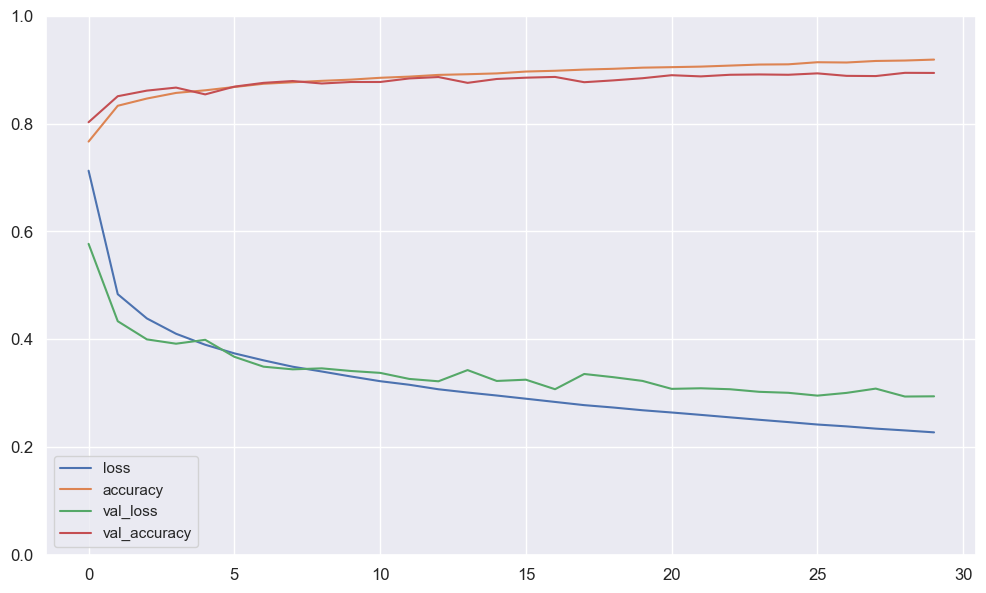

In [24]:
# Chart the learning process
pd.DataFrame(history.history).plot(figsize=(12, 7))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [25]:
# Evaluate on the test data
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 503us/step - loss: 0.3269 - accuracy: 0.8830


[0.3269021809101105, 0.8830000162124634]

In [26]:
# Calculate a confusion matrix
print(class_names)

y_pred = np.argmax(model.predict(X_test), axis=1)
cm = confusion_matrix(y_test, y_pred)
cm

['T-Shirt or Top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']
313/313 [==============================] - 0s 410us/step


array([[888,   1,   5,  14,   3,   1,  81,   0,   7,   0],
       [  5, 969,   0,  19,   2,   0,   5,   0,   0,   0],
       [ 24,   0, 788,  13,  93,   1,  77,   1,   3,   0],
       [ 41,   7,  10, 872,  29,   0,  36,   1,   4,   0],
       [  1,   1,  76,  27, 810,   0,  82,   0,   3,   0],
       [  0,   0,   0,   1,   0, 967,   0,  21,   1,  10],
       [187,   2,  66,  20,  51,   1, 664,   0,   9,   0],
       [  1,   0,   0,   0,   0,  23,   0, 957,   0,  19],
       [  9,   0,   3,   5,   4,   3,   4,   5, 967,   0],
       [  0,   0,   0,   0,   0,  11,   1,  40,   0, 948]])

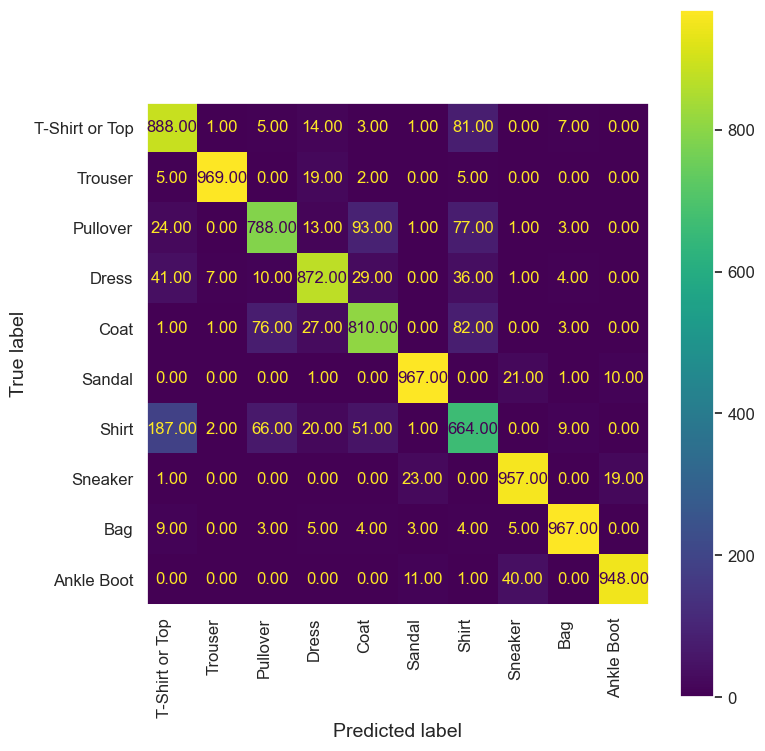

In [27]:
fig, ax = plt.subplots(figsize=(8, 8))

cmdisplay = ConfusionMatrixDisplay(cm, display_labels=class_names)
cmdisplay.plot(values_format='.2f', ax=ax)

plt.grid(b=None)
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

In [28]:
# Get predictions. Note that the predict function returns class probabilities
y_prob = model.predict(X_test)
y_prob[:5]

313/313 [==============================] - 0s 458us/step


array([[1.87942460e-05, 8.33515230e-07, 1.72115949e-06, 2.44545868e-06,
        5.66369499e-06, 1.18112033e-02, 8.60131877e-06, 1.67299993e-02,
        3.18475039e-04, 9.71102297e-01],
       [2.47864547e-04, 7.28088834e-09, 9.96389568e-01, 1.16426175e-08,
        3.06482683e-03, 1.61411353e-11, 2.97643186e-04, 1.01619144e-10,
        5.55689397e-08, 6.19832310e-12],
       [3.68411270e-06, 9.99995708e-01, 5.85221436e-08, 2.17252079e-07,
        3.14530268e-07, 4.17115786e-11, 1.85348306e-08, 1.58113106e-12,
        8.08249745e-10, 2.37910689e-12],
       [1.03098428e-05, 9.99925494e-01, 1.16309070e-06, 5.68411779e-05,
        3.07255868e-06, 1.57361946e-08, 3.11855820e-06, 9.81381532e-10,
        3.15300075e-09, 8.32102121e-09],
       [1.76409483e-01, 2.71772342e-06, 1.25628766e-02, 2.29895202e-04,
        2.46280408e-03, 4.54720386e-08, 8.08267474e-01, 3.50555320e-06,
        6.04447050e-05, 7.50129516e-07]], dtype=float32)

In [29]:
# Get the model's predictions
y_pred = np.argmax(y_prob, axis=1)
y_pred[:5]

array([9, 2, 1, 1, 6])

In [30]:
# Get the probabilities associated with the model's predictions
y_maxprob = np.max(y_prob, axis=1)
y_maxprob[:5]

array([0.9711023 , 0.99638957, 0.9999957 , 0.9999255 , 0.8082675 ],
      dtype=float32)

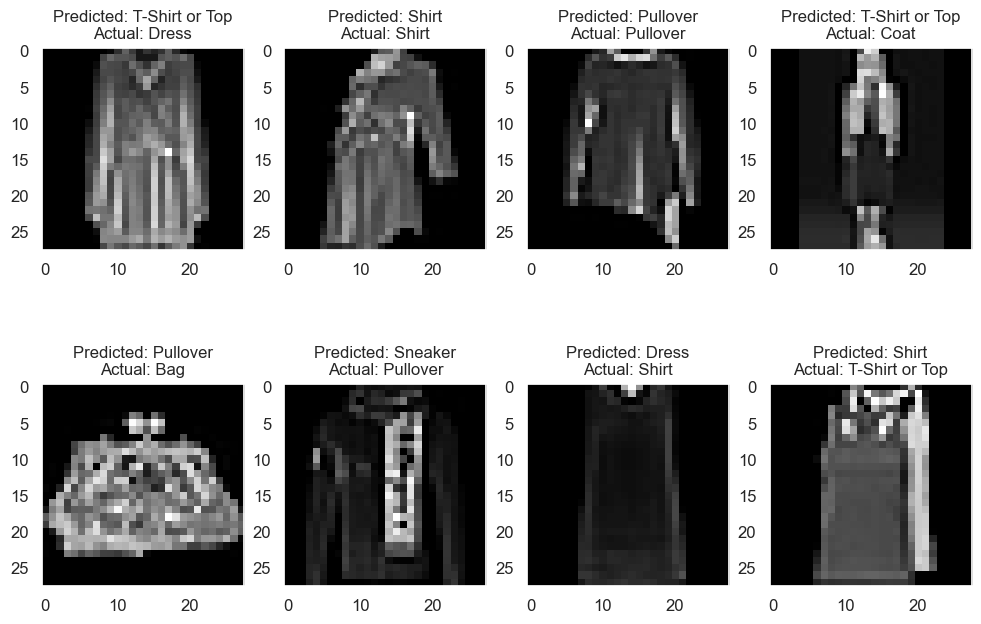

In [31]:
# Show the least confident predictions
fig, ax = plt.subplots(2, 4, figsize=(12, 8))
locs = y_maxprob.argsort()[:10]
for i, a in enumerate(ax.reshape(-1)):
    a.imshow(X_test[locs[i]], cmap='gray')
    a.grid(False)
    a.set_title(f'Predicted: {class_names[y_pred[locs[i]]]}\n'
                f'Actual: {class_names[y_test[locs[i]]]}')

plt.show()

### Exercise

How much can you improve the model by adjusting the structure (e.g., number of layers) or hyperparameters?